# Part 1: Importing the Dataset
Code for importing data and constructing the FFNN are taken from the numpy tutorial: https://numpy.org/numpy-tutorials/tutorial-deep-learning-on-mnist/#id-1-load-the-mnist-dataset

First, define the file names that will be used for the dataset.

In [1]:
data_sources = {
    "training_images": "train-images-idx3-ubyte.gz",  # 60,000 training images.
    "test_images": "t10k-images-idx3-ubyte.gz",  # 10,000 test images.
    "training_labels": "train-labels-idx1-ubyte.gz",  # 60,000 training labels.
    "test_labels": "t10k-labels-idx1-ubyte.gz",  # 10,000 test labels.
}

Create the directory if it doesn't exist. Then, download the dataset if it does not exist.

In [2]:
import requests
import os

data_dir = "./_data"
os.makedirs(data_dir, exist_ok=True)

base_url = "https://ossci-datasets.s3.amazonaws.com/mnist/"

for fname in data_sources.values():
    fpath = os.path.join(data_dir, fname)
    if not os.path.exists(fpath):
        print("Downloading file: " + fname)
        resp = requests.get(base_url + fname, stream=True)
        resp.raise_for_status()  # Ensure download was succesful
        with open(fpath, "wb") as fh:
            for chunk in resp.iter_content(chunk_size=128):
                fh.write(chunk)

Decompress data and store as arrays.

In [3]:
import gzip
import numpy as np

mnist_dataset = {}

# Images
for key in ("training_images", "test_images"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(
            mnist_file.read(), np.uint8, offset=16
        ).reshape(-1, 28 * 28)
# Labels
for key in ("training_labels", "test_labels"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(mnist_file.read(), np.uint8, offset=8)

Split the data in to training and test sets.

In [4]:
x_train, y_train, x_test, y_test = (
    mnist_dataset["training_images"],
    mnist_dataset["training_labels"],
    mnist_dataset["test_images"],
    mnist_dataset["test_labels"],
)

Verify that the data was imported correctly.

The shape of training images: (60000, 784) and training labels: (60000,)
The shape of test images: (10000, 784) and test labels: (10000,)


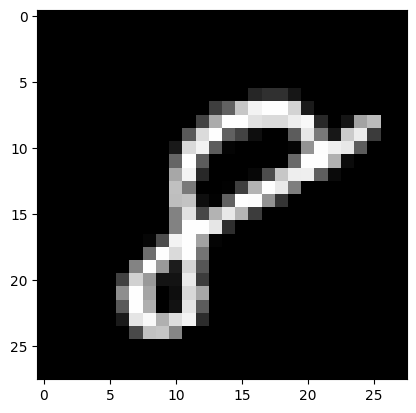

In [5]:
import matplotlib.pyplot as plt

print(
    "The shape of training images: {} and training labels: {}".format(
        x_train.shape, y_train.shape
    )
)
print(
    "The shape of test images: {} and test labels: {}".format(
        x_test.shape, y_test.shape
    )
)

# Take the 60,000th image (indexed at 59,999) from the training set,
# reshape from (784, ) to (28, 28) to have a valid shape for displaying purposes.
mnist_image = x_train[59999, :].reshape(28, 28)
# Set the color mapping to grayscale to have a black background.
plt.imshow(mnist_image, cmap="gray")
# Display the image.
plt.show()

# Part 2: Data Preprocessing

First, convert images to floating point.

In [6]:
# Check type of images before preprocessing
print("The data type of training images: {}".format(x_train.dtype))
print("The data type of test images: {}".format(x_test.dtype))

# Convert to floating point
training_sample, test_sample = 1000, 1000
training_images = x_train[0:training_sample] / 255
test_images = x_test[0:test_sample] / 255

# Check type of images after preprocessing
print("The data type of training images: {}".format(training_images.dtype))
print("The data type of test images: {}".format(test_images.dtype))

The data type of training images: uint8
The data type of test images: uint8
The data type of training images: float64
The data type of test images: float64


Then, convert labels to one-hot encoding.

In [7]:
# Check type of labels before preprocessing
print("The data type of training labels: {}".format(y_train.dtype))
print("The data type of test labels: {}".format(y_test.dtype))

def one_hot_encoding(labels, dimension=10):
    # Define a one-hot variable for an all-zero vector
    # with 10 dimensions (number labels from 0 to 9).
    one_hot_labels = labels[..., None] == np.arange(dimension)[None]
    # Return one-hot encoded labels.
    return one_hot_labels.astype(np.float64)

training_labels = one_hot_encoding(y_train[:training_sample])
test_labels = one_hot_encoding(y_test[:test_sample])

# Check type of labels after preprocessing
print("The data type of training labels: {}".format(training_labels.dtype))
print("The data type of test labels: {}".format(test_labels.dtype))

The data type of training labels: uint8
The data type of test labels: uint8
The data type of training labels: float64
The data type of test labels: float64


# Part 3: Defining the Example FFNN

First, set a random seed and hyperparameters.

In [8]:
seed = 884736743
rng = np.random.default_rng(seed)

learning_rate = 0.005
epochs = 20
hidden_size = 100
pixels_per_image = 784
num_labels = 10

def relu(Z):
    return np.maximum(Z, 0)

def generate_weights(pixels_per_image, hidden_size, num_labels, n_hidden, rng):
    weights, biases = [], []

    weights.append(0.2 * rng.random((pixels_per_image, hidden_size)) - 0.1)
    biases.append(0.2 * rng.random(hidden_size) - 0.1)

    for _ in range(n_hidden - 1):
        weights.append(0.2 * rng.random((hidden_size, hidden_size)) - 0.1)
        biases.append(0.2 * rng.random(hidden_size) - 0.1)

    weights.append(0.2 * rng.random((hidden_size, num_labels)) - 0.1)
    biases.append(0.2 * rng.random(num_labels))

    return weights, biases

weights, biases = generate_weights(pixels_per_image, hidden_size, num_labels, 0, rng)


Then, train the model

In [9]:
def relu2deriv(output):
    return output >= 0

weights_1, weights_2 = weights

# To store training and test set losses and accurate predictions
# for visualization.
store_training_loss = []
store_training_accurate_pred = []
store_test_loss = []
store_test_accurate_pred = []

# This is a training loop.
# Run the learning experiment for a defined number of epochs (iterations).
for j in range(epochs):

    #################
    # Training step #
    #################

    # Set the initial loss/error and the number of accurate predictions to zero.
    training_loss = 0.0
    training_accurate_predictions = 0

    # For all images in the training set, perform a forward pass
    # and backpropagation and adjust the weights accordingly.
    for i in range(len(training_images)):
        # Forward propagation/forward pass:
        # 1. The input layer:
        #    Initialize the training image data as inputs.
        layer_0 = training_images[i]
        # 2. The hidden layer:
        #    Take in the training image data into the middle layer by
        #    matrix-multiplying it by randomly initialized weights.
        layer_1 = np.dot(layer_0, weights_1)
        # 3. Pass the hidden layer's output through the ReLU activation function.
        layer_1 = relu(layer_1)
        # 4. Define the dropout function for regularization.
        dropout_mask = rng.integers(low=0, high=2, size=layer_1.shape)
        # 5. The output layer:
        #    Ingest the output of the middle layer into the the final layer
        #    by matrix-multiplying it by randomly initialized weights.
        #    Produce a 10-dimension vector with 10 scores.
        layer_2 = np.dot(layer_1, weights_2)

        # Backpropagation/backward pass:
        # 1. Measure the training error (loss function) between the actual
        #    image labels (the truth) and the prediction by the model.
        training_loss += np.sum((training_labels[i] - layer_2) ** 2)
        # 2. Increment the accurate prediction count.
        training_accurate_predictions += int(
            np.argmax(layer_2) == np.argmax(training_labels[i])
        )
        # 3. Differentiate the loss function/error.
        layer_2_delta = training_labels[i] - layer_2
        # 4. Propagate the gradients of the loss function back through the hidden layer.
        layer_1_delta = np.dot(weights_2, layer_2_delta) * relu2deriv(layer_1)
        # 5. Apply the dropout to the gradients.
        layer_1_delta *= dropout_mask
        # 6. Update the weights for the middle and input layers
        #    by multiplying them by the learning rate and the gradients.
        weights_1 += learning_rate * np.outer(layer_0, layer_1_delta)
        weights_2 += learning_rate * np.outer(layer_1, layer_2_delta)

    # Store training set losses and accurate predictions.
    store_training_loss.append(training_loss)
    store_training_accurate_pred.append(training_accurate_predictions)

    ###################
    # Evaluation step #
    ###################

    # Evaluate model performance on the test set at each epoch.

    # Unlike the training step, the weights are not modified for each image
    # (or batch). Therefore the model can be applied to the test images in a
    # vectorized manner, eliminating the need to loop over each image
    # individually:

    results = relu(test_images @ weights_1) @ weights_2

    # Measure the error between the actual label (truth) and prediction values.
    test_loss = np.sum((test_labels - results) ** 2)

    # Measure prediction accuracy on test set
    test_accurate_predictions = np.sum(
        np.argmax(results, axis=1) == np.argmax(test_labels, axis=1)
    )

    # Store test set losses and accurate predictions.
    store_test_loss.append(test_loss)
    store_test_accurate_pred.append(test_accurate_predictions)

    # Summarize error and accuracy metrics at each epoch
    print(
        (
            f"Epoch: {j}\n"
            f"  Training set error: {training_loss / len(training_images):.3f}\n"
            f"  Training set accuracy: {training_accurate_predictions / len(training_images)}\n"
            f"  Test set error: {test_loss / len(test_images):.3f}\n"
            f"  Test set accuracy: {test_accurate_predictions / len(test_images)}"
        )
    )

Epoch: 0
  Training set error: 0.705
  Training set accuracy: 0.573
  Test set error: 0.653
  Test set accuracy: 0.628
Epoch: 1
  Training set error: 0.513
  Training set accuracy: 0.792
  Test set error: 0.596
  Test set accuracy: 0.69
Epoch: 2
  Training set error: 0.463
  Training set accuracy: 0.82
  Test set error: 0.574
  Test set accuracy: 0.72
Epoch: 3
  Training set error: 0.427
  Training set accuracy: 0.845
  Test set error: 0.549
  Test set accuracy: 0.732
Epoch: 4
  Training set error: 0.399
  Training set accuracy: 0.86
  Test set error: 0.532
  Test set accuracy: 0.755
Epoch: 5
  Training set error: 0.383
  Training set accuracy: 0.865
  Test set error: 0.516
  Test set accuracy: 0.762
Epoch: 6
  Training set error: 0.366
  Training set accuracy: 0.883
  Test set error: 0.507
  Test set accuracy: 0.755
Epoch: 7
  Training set error: 0.355
  Training set accuracy: 0.881
  Test set error: 0.501
  Test set accuracy: 0.771
Epoch: 8
  Training set error: 0.347
  Training set 

Visualize the training results

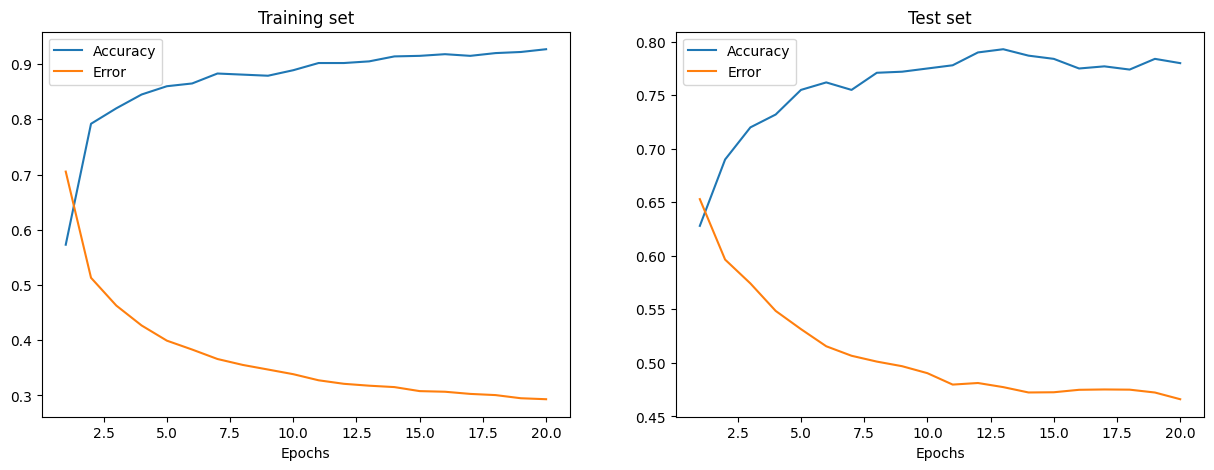

In [10]:
epoch_range = np.arange(epochs) + 1  # Starting from 1

# The training set metrics.
training_metrics = {
    "accuracy": np.asarray(store_training_accurate_pred) / len(training_images),
    "error": np.asarray(store_training_loss) / len(training_images),
}

# The test set metrics.
test_metrics = {
    "accuracy": np.asarray(store_test_accurate_pred) / len(test_images),
    "error": np.asarray(store_test_loss) / len(test_images),
}

# Display the plots.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for ax, metrics, title in zip(
    axes, (training_metrics, test_metrics), ("Training set", "Test set")
):
    # Plot the metrics
    for metric, values in metrics.items():
        ax.plot(epoch_range, values, label=metric.capitalize())
    ax.set_title(title)
    ax.set_xlabel("Epochs")
    ax.legend()
plt.show()

# Part 4: Apply constraint solving to MNIST Example

First, generate the constraints for the weights and biases used in the example

In [11]:
import constraints.generate_constraints as gen

weights_example = weights
biases_example = [np.zeros(b.shape) for b in biases] # The example uses no bias terms

constraints, xs, ys = gen.generate_constraints(weights_example, biases_example)

100%|██████████| 1/1 [00:00<00:00, 196.11it/s]


In [12]:
num_constraints_mnist = len(constraints) + len(ys[-1])
non_linear_mnist = gen.generate_relu_constraints(xs, ys)

print(f"Total number of constraints: {num_constraints_mnist}, Number of non-linear constraints: {len(non_linear_mnist)}")

100%|██████████| 1/1 [00:00<00:00, 188.83it/s]

Total number of constraints: 1788, Number of non-linear constraints: 100


Next, we add the constraints to a Z3 solver and try to use the solver to verify some safety property. In this case, we want to say that all of the output values are non-negative.

To verify this property, we add the above constraints to the solver, and then add the negation of the property we want to verify. We do so because the solver can either find a satisfying assignment of variables for the constraints (i.e. the solver returns 'sat'), determine that the constraints are unsatisfiable (i.e. the solver returns 'unsat'), or return an inconclusive result if the solver fails to do either (caused by timeout or other issues).

Hence, if we want to prove that the assumptions for the FFNN, P, imply some property Q (i.e. P ==> Q), we need to ask the solver if the negation of this formula (i.e. not (P ==> Q)) is unsatisfiable. Here P, are the constraints we generated above. Rewriting the above, we want the solver to determine if:

    not (not P \/ Q), i.e. P /\ (not Q)

is unsatisfiable.

In [ ]:
import z3

s = z3.Solver()
s.set('timeout', 300000)
s.add(constraints) # Add the generated constraints

# Construct the constraint for the property we want to check
output_vec = ys[-1]
safety = z3.And([yvar >= 0 for yvar in output_vec])

s.add(z3.Not(safety))
s.check()

We see above that the solver returns 'unknown' meaning that it timed out before being able to determine if the constraints are satisfiable or not. Let's try doing the same thing for a smaller example.

In [23]:
def generate_weights_nonneg(pixels_per_image, hidden_size, num_labels, n_hidden, rng):
    weights, biases = [], []

    weights.append(rng.random((pixels_per_image, hidden_size)))
    biases.append(rng.random(hidden_size))

    for _ in range(n_hidden - 1):
        weights.append(rng.random((hidden_size, hidden_size)))
        biases.append(rng.random(hidden_size))

    weights.append(rng.random((hidden_size, num_labels)))
    biases.append(rng.random(num_labels))

    return weights, biases

weights_small, biases_small = generate_weights(2, 3, 3, 1, rng)

constraints_small, xs_small, ys_small = gen.generate_constraints(weights_small, biases_small)
s = z3.Solver()
s.set('timeout', 300000)
s.add(constraints_small)

out_small = ys_small[-1]
safety_small = z3.And([yvar >= 0 for yvar in out_small])
s.add(z3.Not(safety_small))

s.check()

100%|██████████| 1/1 [00:00<00:00, 1261.07it/s]


unsat

# Part 5: Experiments

In Part 4, we saw that even for a simple image classifier with only two linear layers, the number of constraints required caused the solver to time out. In this section, we will run some experiments to see how this approach to verifying neural networks scales.

In [15]:
n_runs = 3
input_size = 10
hidden_layer_size = 10
n_labels = 5
timeout = 300000 # Timeout in ms

def output_constraints(ys):
    output = ys[-1]
    return z3.And([yvar >= 0 for yvar in output])

In the first experiment, we see how the solver runtime scales with the number of hidden layers in the network

In [58]:
import time
import csv
# Experiment 1: Verification time with number of layers
# For these experiments, use a fixed input size of 10, hidden layer size of 10, and number of labels of 5

n_hidden_layers = [0, 2, 4, 6, 8]
results = []
num_constraints = []
decisions = []

for n_layers in n_hidden_layers:
    times = []
    sats = []
    for _ in range(n_runs):
        W, B = generate_weights(input_size, hidden_layer_size, n_labels, n_layers, rng)
        constraints, xs, ys = gen.generate_constraints(W, B)
        safety = output_constraints(ys)

        s = z3.Solver()
        s.set('timeout', timeout)

        s.add(constraints)
        s.add(z3.Not(safety))

        start = time.time()
        decision = s.check()
        end = time.time()
        times.append(end - start)
        sats.append(decision)

    num_constraints.append(len(constraints))
    results.append(times)
    decisions.append(sats)

100%|██████████| 8/8 [00:00<00:00, 1832.27it/s]


In [59]:
# write results to a .csv file
with open('experiment1.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Results for experiment 1'])
    for i in range(len(results)):
        row = results[i]
        n_layers = n_hidden_layers[i]
        writer.writerow([f"{n_layers + 2} layers: "] + row + [f"Satisfiablility:"] + decisions[i] + [f"Number of constraints: {num_constraints[i]}"])

Next, we see how the solver time scales with the layer size.

In [60]:
# Experiment 2: Verification time with layer size
# In this experiment, use a fixed input size of 10, number of labels of 5, and fixed to only have an input and output layer.
n_layers_fixed = 0

layer_sizes = [10, 20, 30, 40, 50]
results2 = []
num_constraints2 = []
decisions2 = []

for layer_size in layer_sizes:
    times = []
    sats = []
    for _ in range(n_runs):
        W, B = generate_weights(input_size, layer_size, n_labels, n_layers_fixed, rng)
        constraints, xs, ys = gen.generate_constraints(W, B)
        safety = output_constraints(ys)
        

        s = z3.Solver()
        s.set('timeout', timeout)

        s.add(constraints)
        s.add(z3.Not(safety))

        start = time.time()
        decision = s.check()
        end = time.time()
        times.append(end - start)
        sats.append(decision)
        
    num_constraints2.append(len(constraints))
    results2.append(times)
    decisions2.append(sats)

100%|██████████| 1/1 [00:00<00:00, 323.41it/s]


In [61]:
# write results to a .csv file
with open('experiment2.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Times for experiment 2'])
    for i in range(len(results2)):
        row = results2[i]
        layer_size = layer_sizes[i]
        writer.writerow([f"Layer size {layer_size}: "] + row + [f"Satisfiablility:"] + decisions2[i] + [f"Number of constraints: {num_constraints2[i]}"])

## Part 5a: Plots

### Experiment 1 Plots

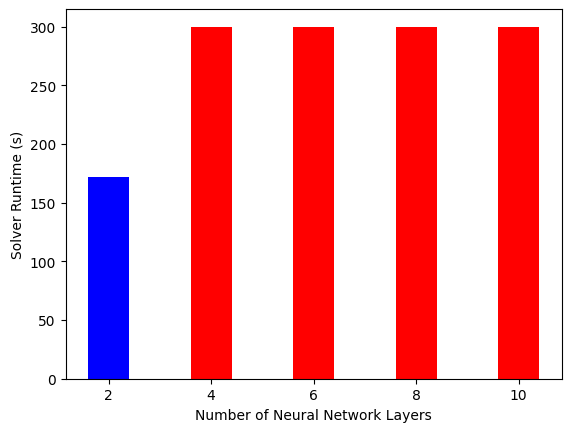

In [67]:
import matplotlib.pyplot as plt

# Plot experiment 1 results
x_vals_1 = [n + 2 for n in n_hidden_layers] 
y_vals_1 = [((101.28291988372803 + 242.11798095703125)/ 2), 300, 300, 300, 300]
colors_1 = ['red' if y >= 300 else 'blue' for y in y_vals_1]

# Create the bar chart
plt.bar(x_vals_1, y_vals_1, color=colors_1)

# Add labels and title
plt.xlabel('Number of Neural Network Layers')
plt.ylabel('Solver Runtime (s)')

plt.savefig('plots/n-layers-runtime-unsat')
plt.show()

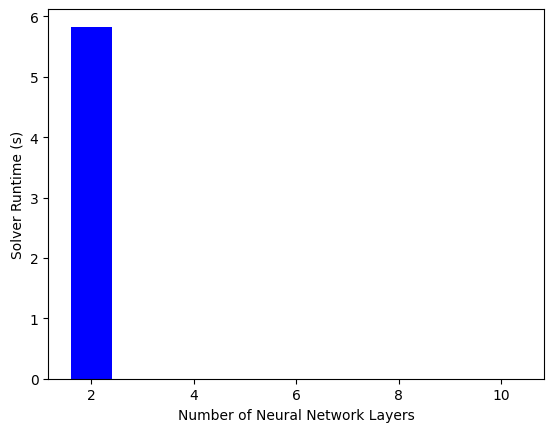

In [69]:
# Experiment 1: Plot runtime for 'sat' results
y_vals_1b = [5.829269170761108, 0, 0, 0, 0]

plt.bar(x_vals_1, y_vals_1b, color=colors_1)
plt.xlabel('Number of Neural Network Layers')
plt.ylabel('Solver Runtime (s)')

plt.savefig('plots/n-layers-runtime-sat')
plt.show()

100%|██████████| 8/8 [00:00<00:00, 2168.02it/s]


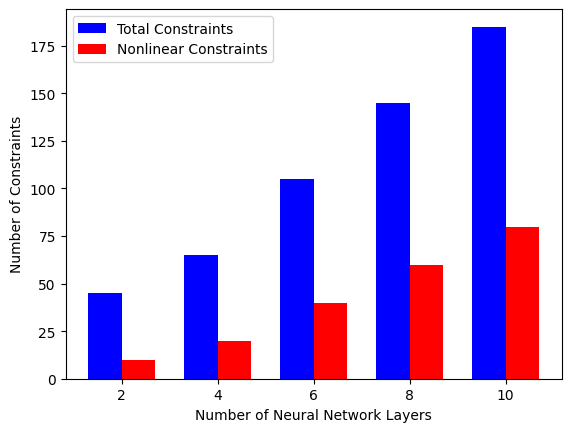

In [74]:
# Experiment 1: Plot the number of constraints and non-linearity constraints

# First, compute the number of non-linear constraints
num_nonlinear = []
for n_layers in n_hidden_layers: 
    W, B = generate_weights(input_size, hidden_layer_size, n_labels, n_layers, rng)
    constraints, xs, ys = gen.generate_constraints(W, B)
    nonlinear = gen.generate_relu_constraints(xs, ys)
    num_nonlinear.append(len(nonlinear))
    

bar_width = 0.35
x_pos = np.arange(len(x_vals_1))

# Create the double bar chart
plt.bar(x_pos - bar_width/2, num_constraints, bar_width, label='Total Constraints', color='blue')
plt.bar(x_pos + bar_width/2, num_nonlinear, bar_width, label='Nonlinear Constraints', color='red')

# Customize the plot
plt.xlabel('Number of Neural Network Layers')
plt.ylabel('Number of Constraints')
plt.xticks(x_pos, x_vals_1)  # Set x-axis labels to your original x values
plt.legend()

plt.savefig('plots/n-layers-constraints')
plt.show()

### Experiment 2 Plots

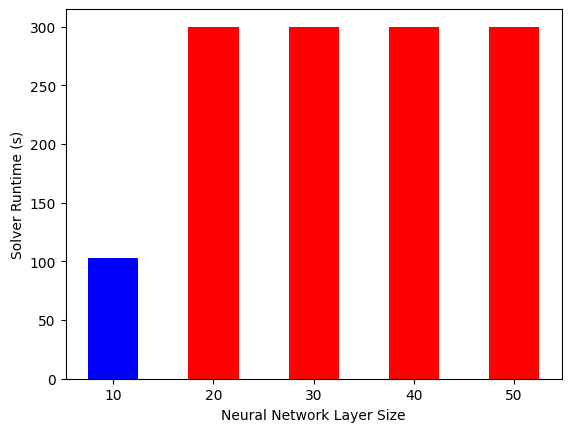

In [78]:
# Plot experiment 2 results
x_vals_2 = layer_sizes
y_vals_2 = [((115.55201411247253+90.02644300460815)/ 2), 300, 300, 300, 300]
colors_2 = ['red' if y >= 300 else 'blue' for y in y_vals_2]

# Create the bar chart
plt.bar(x_vals_2, y_vals_2, 5, color=colors_2,)

# Add labels and title
plt.xlabel('Neural Network Layer Size')
plt.ylabel('Solver Runtime (s)')

plt.savefig('plots/layer-size-runtime-unsat')
plt.show()

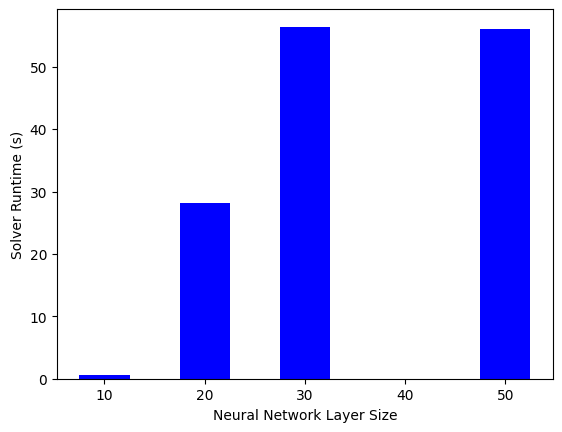

In [81]:
# Experiment 2: Plot runtime for 'sat' results
y_vals_2b = [0.5868270397186279, (51.35321807861328+4.9152820110321045)/2, (17.019169092178345+95.79874801635742)/2, 0, (18.68272590637207+93.27655696868896)/2]

plt.bar(x_vals_2, y_vals_2b, 5, color='blue')
plt.xlabel('Neural Network Layer Size')
plt.ylabel('Solver Runtime (s)')

plt.savefig('plots/layer-size-runtime-sat')
plt.show()

100%|██████████| 1/1 [00:00<00:00, 336.81it/s]


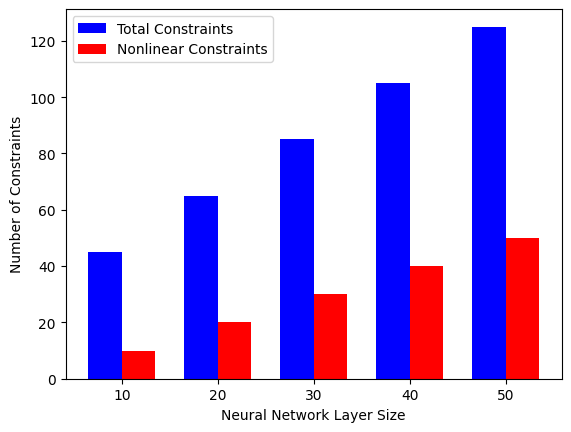

In [ ]:
# Experiment 2: Plot the number of constraints and non-linearity constraints

# First, compute the number of non-linear constraints
num_nonlinear2 = []
for layer_size in layer_sizes: 
    W, B = generate_weights(input_size, layer_size, n_labels, n_layers_fixed, rng)
    constraints, xs, ys = gen.generate_constraints(W, B)
    nonlinear = gen.generate_relu_constraints(xs, ys)
    num_nonlinear2.append(len(nonlinear))
    

bar_width = 0.35
x_pos2 = np.arange(len(layer_sizes))

# Create the double bar chart
plt.bar(x_pos2 - bar_width/2, num_constraints2, bar_width, label='Total Constraints', color='blue')
plt.bar(x_pos2 + bar_width/2, num_nonlinear2, bar_width, label='Nonlinear Constraints', color='red')

# Customize the plot
plt.xlabel('Neural Network Layer Size')
plt.ylabel('Number of Constraints')
plt.xticks(x_pos2, layer_sizes)  # Set x-axis labels to your original x values
plt.legend()

plt.savefig('plots/layer-size-constraints')
plt.show()

## Part 6: Additional Experiments

In part 5, we saw how the solver runtime grows very quickly with the number of layers/layer size. In this section, we run some additional experiments to determine the role that the non-linear constraints play in this blowup. For the purposes of these experiments, we create a new variant of constraint generation that replaces the ReLU activation with the identity function.

In [19]:
results3 = []
decisions3 = []

for n_layers in n_hidden_layers:
    times3 = []
    sats3 = []
    for _ in range(n_runs):
        W, B = generate_weights_nonneg(input_size, hidden_layer_size, n_labels, n_layers, rng)
        constraints, xs, ys = gen.generate_constraints_no_nonlinearity(W, B)
        safety = output_constraints(ys)

        s = z3.Solver()
        s.set('timeout', timeout)

        s.add(constraints)
        s.add(z3.Not(safety))

        start = time.time()
        decision = s.check()
        end = time.time()
        times3.append(end - start)
        sats3.append(decision)

    results3.append(times3)
    decisions3.append(sats3)

100%|██████████| 8/8 [00:00<00:00, 12719.65it/s]


In [20]:
# write results to a .csv file
with open('results/experiment3.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Results for experiment 3'])
    for i in range(len(results3)):
        row = results3[i]
        n_layers = n_hidden_layers[i]
        writer.writerow([f"{n_layers + 2} layers: "] + row + [f"Satisfiablility:"] + decisions3[i])

In [21]:
# Experiment 4: Verification time with layer size using only linear constraints
# In this experiment, use a fixed input size of 10, number of labels of 5, and fixed to only have an input and output layer.
n_layers_fixed = 0

layer_sizes = [10, 20, 30, 40, 50]
results4 = []
decisions4 = []

for layer_size in layer_sizes:
    times = []
    sats = []
    for _ in range(n_runs):
        W, B = generate_weights_nonneg(input_size, layer_size, n_labels, n_layers_fixed, rng)
        constraints, xs, ys = gen.generate_constraints_no_nonlinearity(W, B)
        safety = output_constraints(ys)
        
        s = z3.Solver()
        s.set('timeout', timeout)

        s.add(constraints)
        s.add(z3.Not(safety))

        start = time.time()
        decision = s.check()
        end = time.time()
        times.append(end - start)
        sats.append(decision)
        
    results4.append(times)
    decisions4.append(sats)

100%|██████████| 1/1 [00:00<00:00, 1503.87it/s]


In [22]:
# write results to a .csv file
with open('results/experiment4.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Times for experiment 4'])
    for i in range(len(results4)):
        row = results4[i]
        layer_size = layer_sizes[i]
        writer.writerow([f"Layer size {layer_size}: "] + row + [f"Satisfiablility:"] + decisions4[i])

Plotting the results:

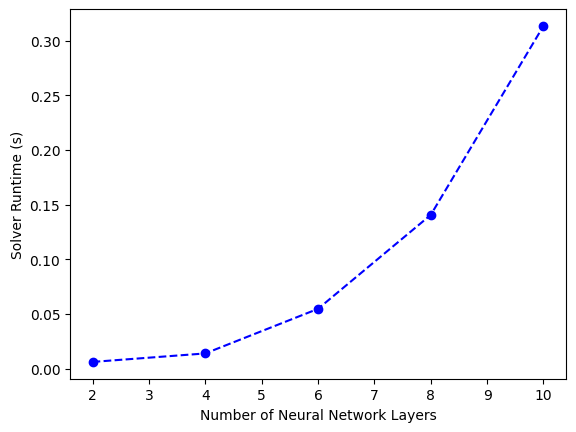

In [28]:
import matplotlib.pyplot as plt

# Plot experiment 3 results
x_vals_1 = [n + 2 for n in n_hidden_layers] 
y_vals_3 = [sum(row)/len(row) for row in results3]

# Create the bar chart
plt.plot(x_vals_1, y_vals_3, color='blue', linestyle='dashed', marker='o')

# Add labels and title
plt.xlabel('Number of Neural Network Layers')
plt.ylabel('Solver Runtime (s)')

plt.savefig('plots/n-layers-runtime-no-nonlinear')
plt.show()

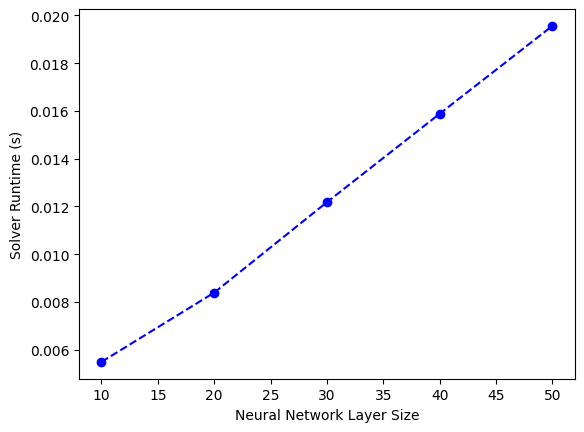

In [29]:
# Plot experiment 4 results
x_vals_2 = layer_sizes
y_vals_4 = [sum(row)/len(row) for row in results4]

# Create the bar chart
plt.plot(x_vals_2, y_vals_4, color='blue', linestyle='dashed', marker='o')

# Add labels and title
plt.xlabel('Neural Network Layer Size')
plt.ylabel('Solver Runtime (s)')

plt.savefig('plots/layer-size-runtime-no-nonlinear')
plt.show()